Install Required Packages

In [ ]:
%%shell
pip install tensorflow-addons
pip install tensorflow-datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# Disable progress bar for TensorFlow datasets
tfds.disable_progress_bar()

# Enable automatic tuning for performance optimization
autotune = tf.data.AUTOTUNE

# Set global mixed-precision policy for better performance
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Preparing the dataset

**Dataset Description:**  CGTrainTest is a mini version of Imagenet, ideal for training CycleGAN models for captivating image colorization.

**Link to Dataset:** [Kaggle CGTrainTest](https://www.kaggle.com/datasets/eswardivi/cgtraintest)


Downloading Dataset

In [ ]:
%%shell

# Create the kaggle.json file with your credentials
echo '{"username":"eswardivi","key":"fa0af4628f04f3801f29e7749a2acc51"}' > kaggle.json

# Move the kaggle.json file to the ~/.kaggle/ directory
mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/kaggle.json

# Set permissions for the kaggle.json file
chmod 600 ~/.kaggle/kaggle.json

kaggle datasets download -d eswardivi/cgtraintest

Extracting Dataset

In [ ]:
%%shell
unzip ./cgtraintest.zip

In [ ]:
import os
import shutil

def move_files_to_new_folder(source_folder, destination_folder, percentage=0.2):
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Get the list of files in the source folder
    files = os.listdir(source_folder)

    # Calculate the number of files to move (percentage of the total)
    num_files_to_move = int(len(files) * percentage)

    # Get the first percentage of files
    files_to_move = files[:num_files_to_move]

    # Move the selected files to the destination folder
    for file_name in files_to_move:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.move(source_path, destination_path)

    print("Files moved successfully.")

# Move 20% of files from the source folder to the destination folder
move_files_to_new_folder('./trainA', './trainA_New')
move_files_to_new_folder('./trainB', './trainB_New')
move_files_to_new_folder('./testA', './testA_New')
move_files_to_new_folder('./testB', './testB_New')

In [ ]:
%%shell
rm -rf trainA trainB testB testA

In [ ]:
from PIL import Image
import os

def convert_images_in_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + ".png")

        # Open the image and convert to PNG if the format is supported
        img = Image.open(input_path)
        img.save(output_path, "PNG")
        print(f"Converted {filename} to PNG.")

# Convert images in the specified folders
convert_images_in_folder('./trainA_New', './trainA')
convert_images_in_folder('./trainB_New', './trainB')
convert_images_in_folder('./testA_New', './testA')
convert_images_in_folder('./testB_New', './testB')


# Data Loading

In [ ]:
train_A=tf.keras.utils.image_dataset_from_directory('./trainA',label_mode=None,shuffle=False,class_names=None,batch_size=None,image_size=(224, 224))
train_B=tf.keras.utils.image_dataset_from_directory('./trainB',label_mode=None,shuffle=False,class_names=None,batch_size=None,image_size=(224, 224))

test_A=tf.keras.utils.image_dataset_from_directory('./testA',label_mode=None,shuffle=False,class_names=None,batch_size=None,image_size=(224, 224))
test_B=tf.keras.utils.image_dataset_from_directory('./testB',label_mode=None,shuffle=False,class_names=None,batch_size=None,image_size=(224, 224))

In [ ]:
# Define the standard image size.
orig_img_size = (224, 224)
# Size of the random crops to be used during training.
input_img_size = (224, 224, 3)
# Weights initializer for the layers.
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float16)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


Creating Dataset Objects for Better Data Pipeline

In [ ]:
# Apply the preprocessing operations to the training data for Domain A
train_A = (
    train_A.map(preprocess_train_image, num_parallel_calls=autotune)   # Preprocess each image in parallel
    .cache()  # Cache the preprocessed data for faster retrieval during training
    .shuffle(buffer_size)  # Shuffle the data to introduce randomness during training
    .batch(batch_size)  # Group images into batches for training
)
train_B = (
    train_B.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_A = (
    test_A.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
test_B = (
    test_B.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)



# Let us See Some Samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize_img(img):
    return ((img * 127.5) + 127.5).numpy().astype(np.uint8)

def visualize_image_pairs(pair_list, title_list):
    num_pairs = len(pair_list)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))
    for i, (image_A, image_B) in enumerate(pair_list):
        ax1, ax2 = axes[i]

        if len(image_A.shape) == 4:  # Check if it's a batched image
            image_A = image_A[0]  # Choose the first image from the batch
            image_B = image_B[0]

        ax1.imshow(denormalize_img(image_A))
        ax1.set_title(title_list[0], fontsize=14)
        ax1.axis("off")

        ax2.imshow(denormalize_img(image_B))
        ax2.set_title(title_list[1], fontsize=14)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

# Create a list of image pairs from train_A and train_B
image_pairs = list(zip(train_A.take(4), train_B.take(4)))

# Titles for the image pairs
titles = ["GrayScale", "Color"]

# Visualize the image pairs
visualize_image_pairs(image_pairs, titles)


# Making CycleGan Generators and Discriminators

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(x, activation, kernel_initializer=kernel_init,
                   kernel_size=(3, 3), strides=(1, 1), padding="valid",
                   gamma_initializer=gamma_init, use_bias=False):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides,
                      kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides,
                      kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(x, filters, activation, kernel_initializer=kernel_init,
               kernel_size=(3, 3), strides=(2, 2), padding="same",
               gamma_initializer=gamma_init, use_bias=False):
    x = layers.Conv2D(filters, kernel_size, strides=strides,
                      kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2),
             padding="same", kernel_initializer=kernel_init,
             gamma_initializer=gamma_init, use_bias=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides,
                               padding=padding,
                               kernel_initializer=kernel_initializer,
                               use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


# Generators

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=3,
    num_residual_blocks=5,
    num_upsample_blocks=3,
    gamma_initializer=gamma_init,
    name=None,
):
    # Input layer for the generator model
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")

    # Initial convolution block
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling blocks
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling blocks
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)  # Output with 3 channels for RGB images
    x = layers.Activation("tanh")(x)  # Output activation to map values to [-1, 1]

    # Create the generator model
    model = tf.keras.models.Model(img_input, x, name=name)
    return model

# Discriminators

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=5, name=None
):
    # Input layer for the discriminator model
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")

    # First convolutional block
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    # Downsampling blocks
    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    # Final convolutional block
    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    # Create the discriminator model
    model = tf.keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [ ]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")
tf.keras.utils.plot_model(gen_G, show_shapes=True, show_layer_names=True)

In [ ]:
# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")
tf.keras.utils.plot_model(disc_X, show_shapes=True, show_layer_names=True)

# Cycle GAN Model

In [ ]:

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Grayscale and y is Color
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Inference

In [ ]:
# Load the checkpoints
weight_file = "./model_checkpoints/cyclegan_checkpoints.002"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, img in enumerate(test_A.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

# Inference

Weights loaded successfully


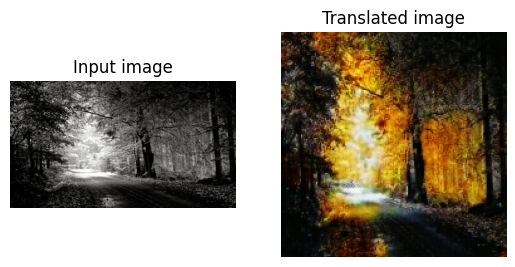

In [ ]:
weight_file = "/content/content/model_checkpoints/cyclegan_checkpoints.010"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")
custom_img = tf.io.read_file("/content/desktop-728x410.jpg")
custom_img = tf.image.decode_jpeg(custom_img, channels=3)
preprocessed_img = preprocess_image(custom_img)
preprocessed_img = tf.expand_dims(preprocessed_img, axis=0)
prediction = cycle_gan_model.gen_G(preprocessed_img, training=False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(custom_img)
ax[1].imshow(prediction)
ax[0].set_title("Input image")
ax[1].set_title("Translated image")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

# Demo

Saving desktop-728x410.jpg to desktop-728x410 (3).jpg
Weights from /content/content/model_checkpoints/cyclegan_checkpoints.001 loaded successfully


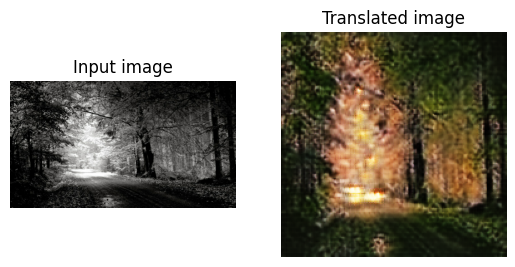

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.002 loaded successfully


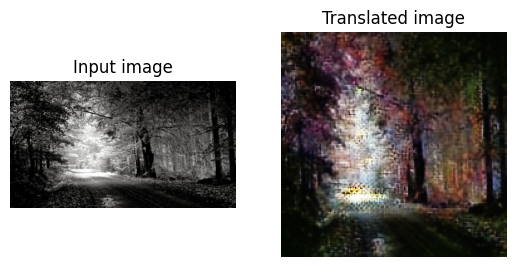

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.003 loaded successfully


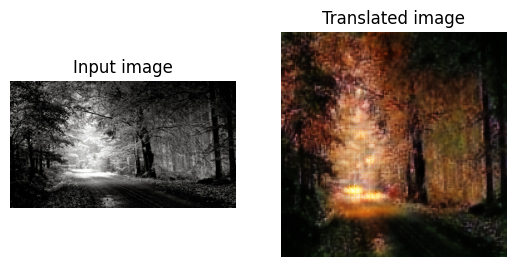

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.004 loaded successfully


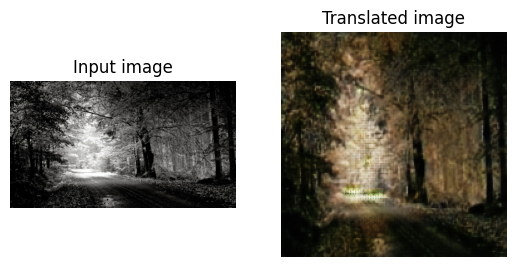

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.005 loaded successfully


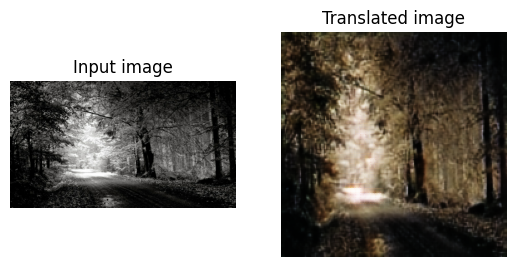

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.006 loaded successfully


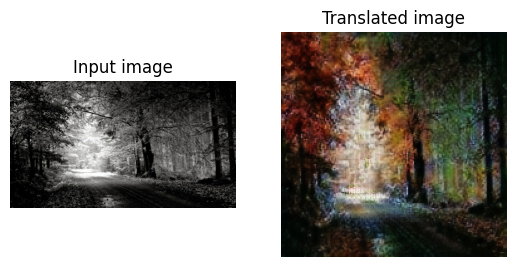

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.007 loaded successfully


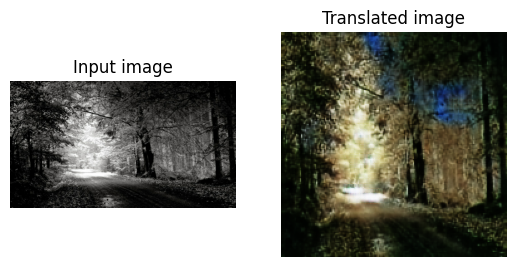

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.008 loaded successfully


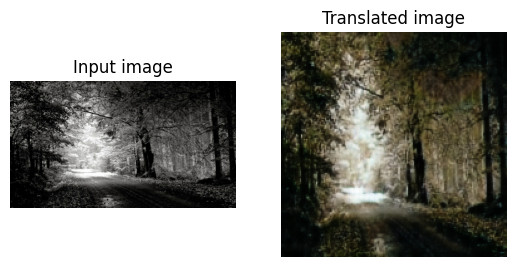

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.009 loaded successfully


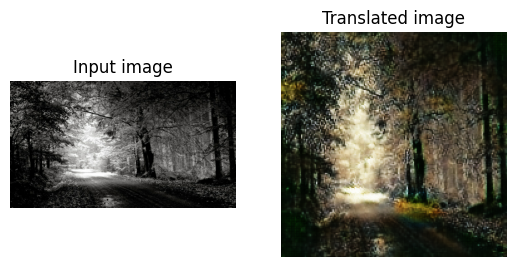

Weights from /content/content/model_checkpoints/cyclegan_checkpoints.010 loaded successfully


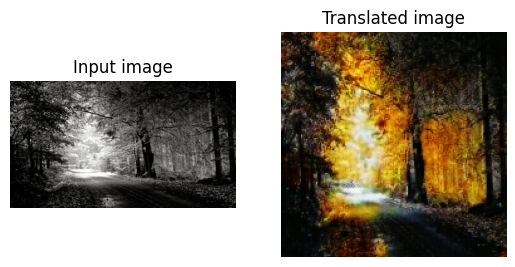

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Define the necessary functions and preprocess_image as shown in the previous responses

weight_files = [
    "/content/content/model_checkpoints/cyclegan_checkpoints.001",
    "/content/content/model_checkpoints/cyclegan_checkpoints.002",
    "/content/content/model_checkpoints/cyclegan_checkpoints.003",
    "/content/content/model_checkpoints/cyclegan_checkpoints.004",
    "/content/content/model_checkpoints/cyclegan_checkpoints.005",
    "/content/content/model_checkpoints/cyclegan_checkpoints.006",
    "/content/content/model_checkpoints/cyclegan_checkpoints.007",
    "/content/content/model_checkpoints/cyclegan_checkpoints.008",
    "/content/content/model_checkpoints/cyclegan_checkpoints.009",
    "/content/content/model_checkpoints/cyclegan_checkpoints.010",
]

# Upload the image file
uploaded = files.upload()

for weight_file in weight_files:
    # Load the weights for each checkpoint
    cycle_gan_model.load_weights(weight_file).expect_partial()
    print(f"Weights from {weight_file} loaded successfully")

    # Generate translated image for the custom image
    custom_img = tf.io.decode_image(next(iter(uploaded.values())), channels=3)
    preprocessed_img = preprocess_image(custom_img)
    preprocessed_img = tf.expand_dims(preprocessed_img, axis=0)
    prediction = cycle_gan_model.gen_G(preprocessed_img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    # Display the input and translated images
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(custom_img)
    ax[1].imshow(prediction)
    ax[0].set_title("Input image")
    ax[1].set_title("Translated image")
    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()
